
Processing Memory Utilization with Simple Isolation Forest:
  NETWORKDELAY:
    Cleaned 10 outliers (2.0%) using 1 original features
  BASELINE:
    Cleaned 8 outliers (1.6%) using 1 original features

Processing Memory Cache with Simple Isolation Forest:
  NETWORKDELAY:
    Cleaned 9 outliers (1.8%) using 1 original features
  BASELINE:
    Cleaned 8 outliers (1.6%) using 1 original features

Processing Memory Available with Simple Isolation Forest:
  NETWORKDELAY:
    Cleaned 10 outliers (2.0%) using 1 original features
  BASELINE:
    Cleaned 8 outliers (1.6%) using 1 original features

COMPREHENSIVE MEMORY NETWORK DELAY ANALYSIS

Analyzing Memory Utilization...

Plotting original memory data for Memory Utilization...
  Showing all 1 memory metrics


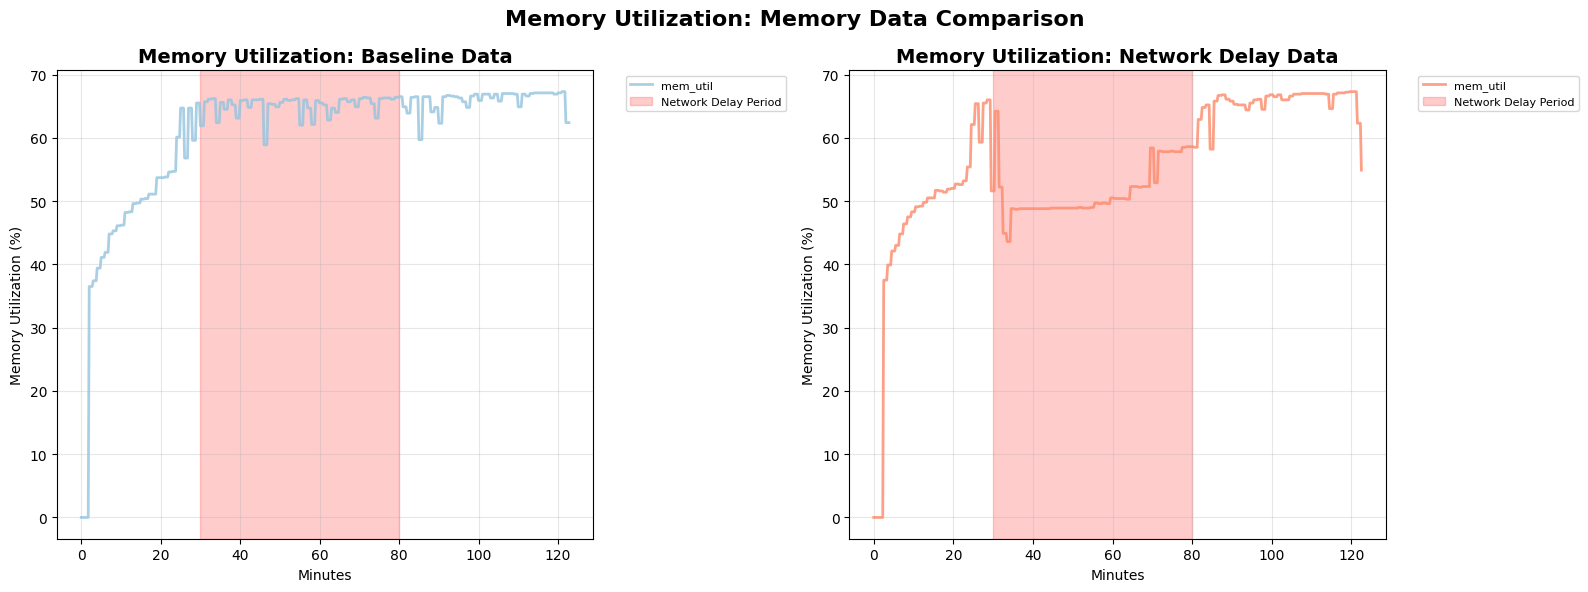

  Displayed all 1 memory columns: mem_util


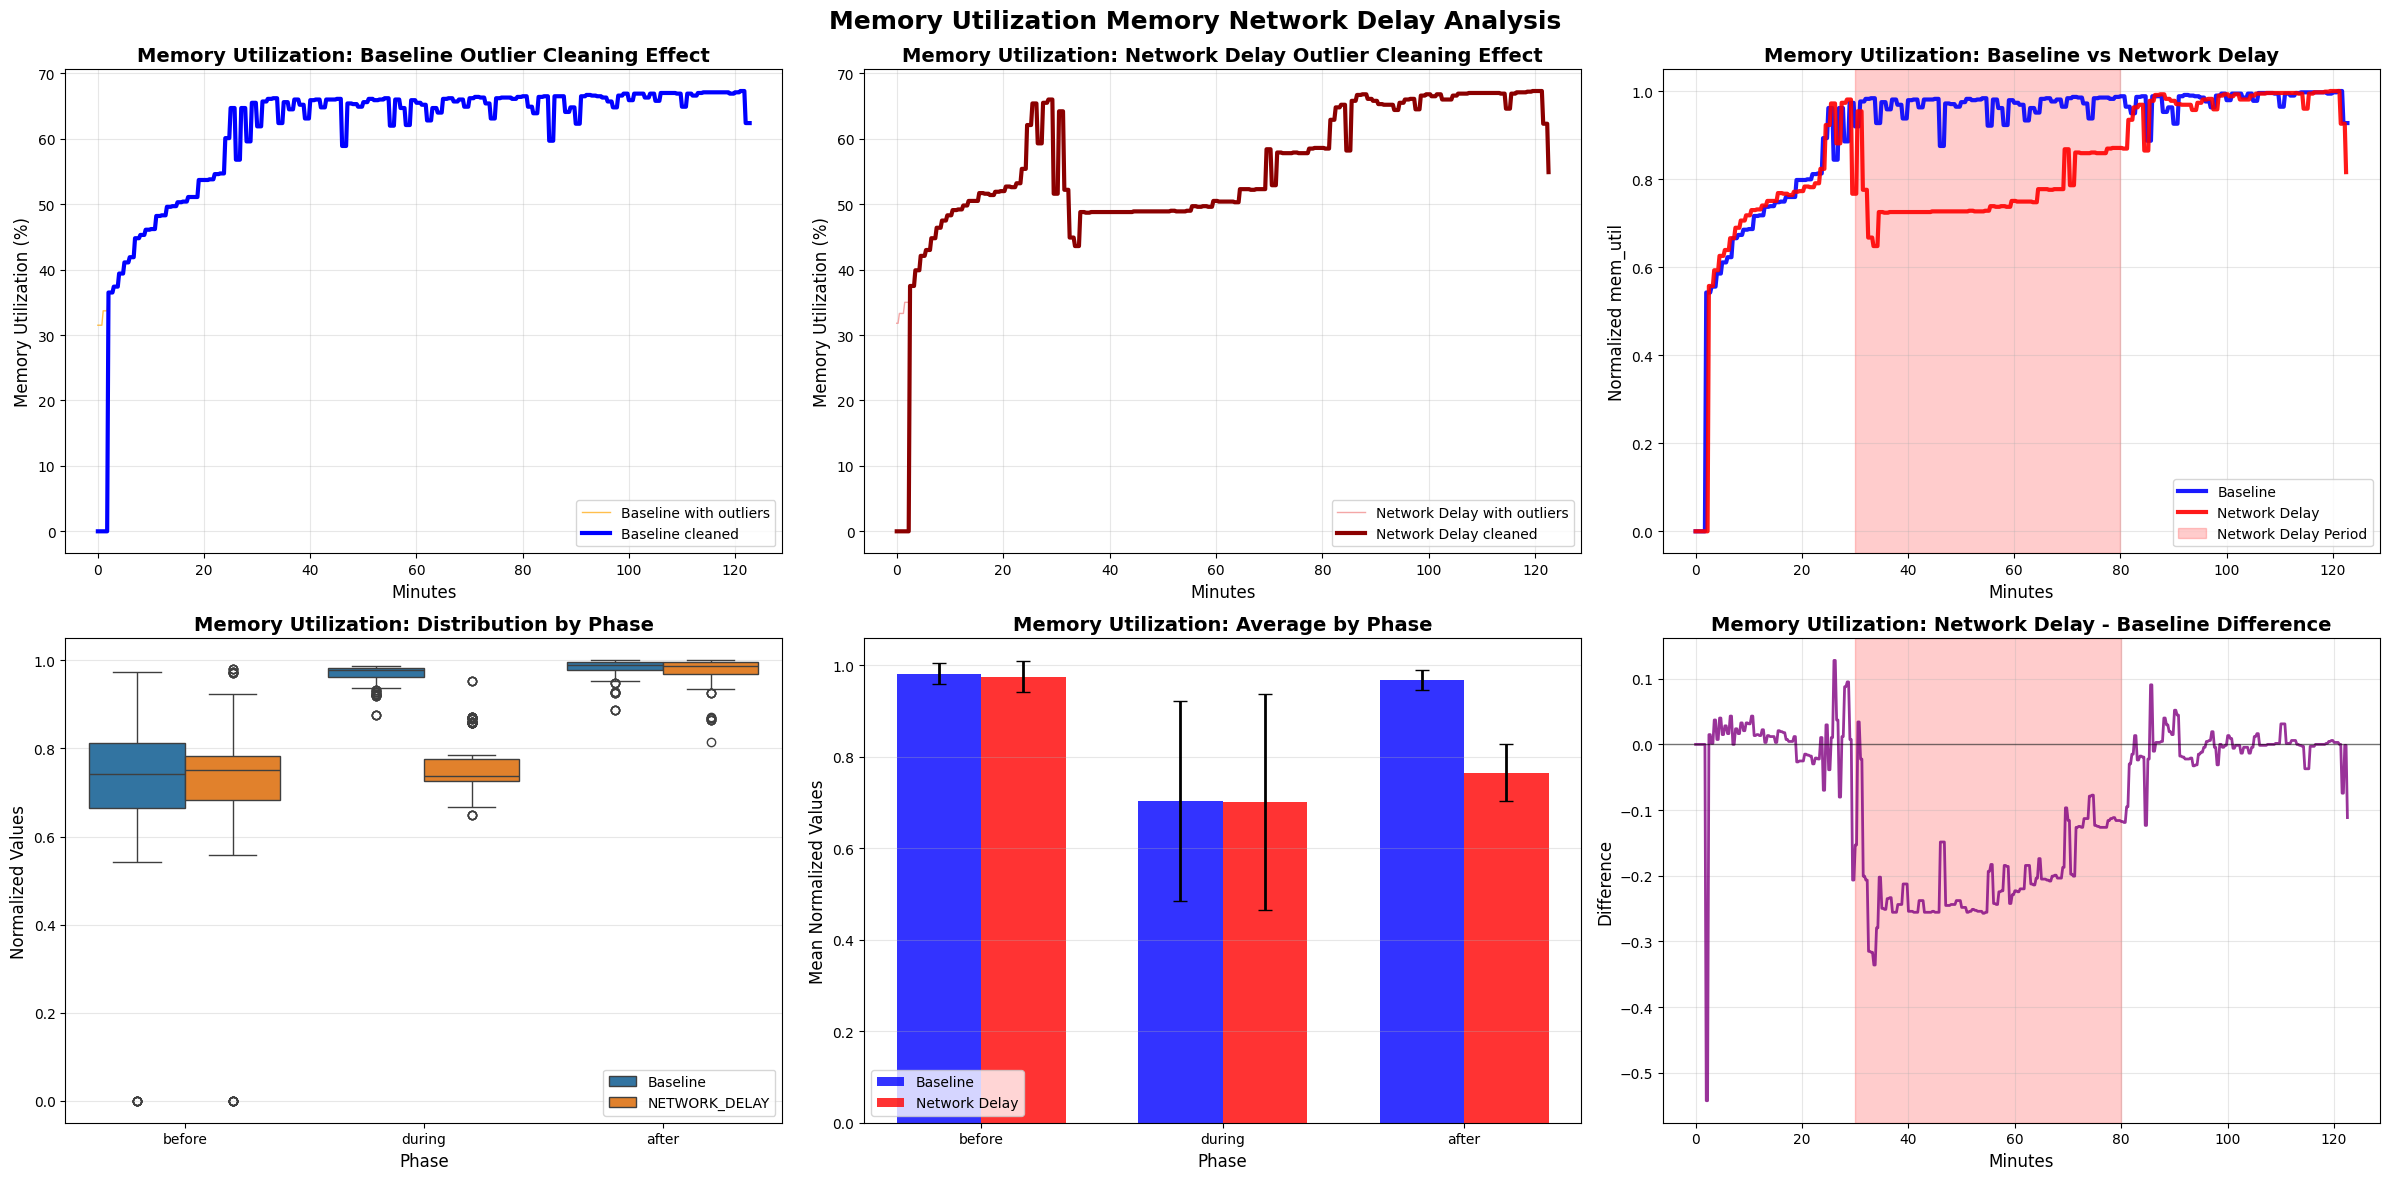


MEMORY UTILIZATION - NETWORK DELAY ANALYSIS RESULTS

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9813  0.0230  0.8871  1.0000
before  0.7030  0.2191  0.0000  0.9733
during  0.9678  0.0229  0.8752  0.9881

NETWORK DELAY STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9752  0.0331  0.8158  1.0000
before  0.7009  0.2354  0.0000  0.9807
during  0.7653  0.0618  0.6478  0.9539

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  0.07, p=  0.9449 (NOT SIGNIFICANT)
  DURING  : t= 43.58, p=  0.0000 (SIGNIFICANT)
  AFTER   : t=  1.99, p=  0.0470 (SIGNIFICANT)

NETWORK DELAY IMPACT ON MEMORY:
  BEFORE  :   -0.29% (DECREASE)
  DURING  :  -20.93% (DECREASE)
  AFTER   :   -0.63% (DECREASE)

MEMORY METRICS SUMMARY:
  Numeric columns found: ['mem_util']
  Main metric analyzed: mem_util
  Total metrics: 1

Analyzing Memory Cache...

Plotting original memory data for Memory

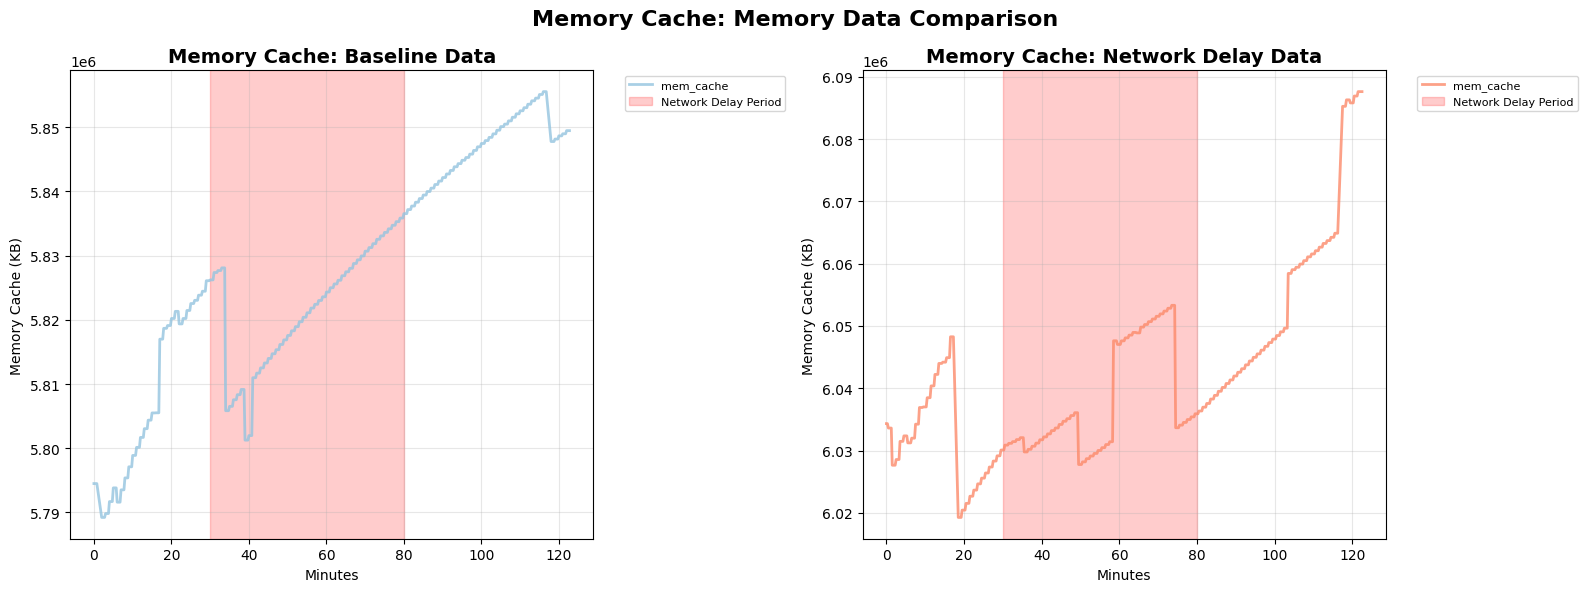

  Displayed all 1 memory columns: mem_cache


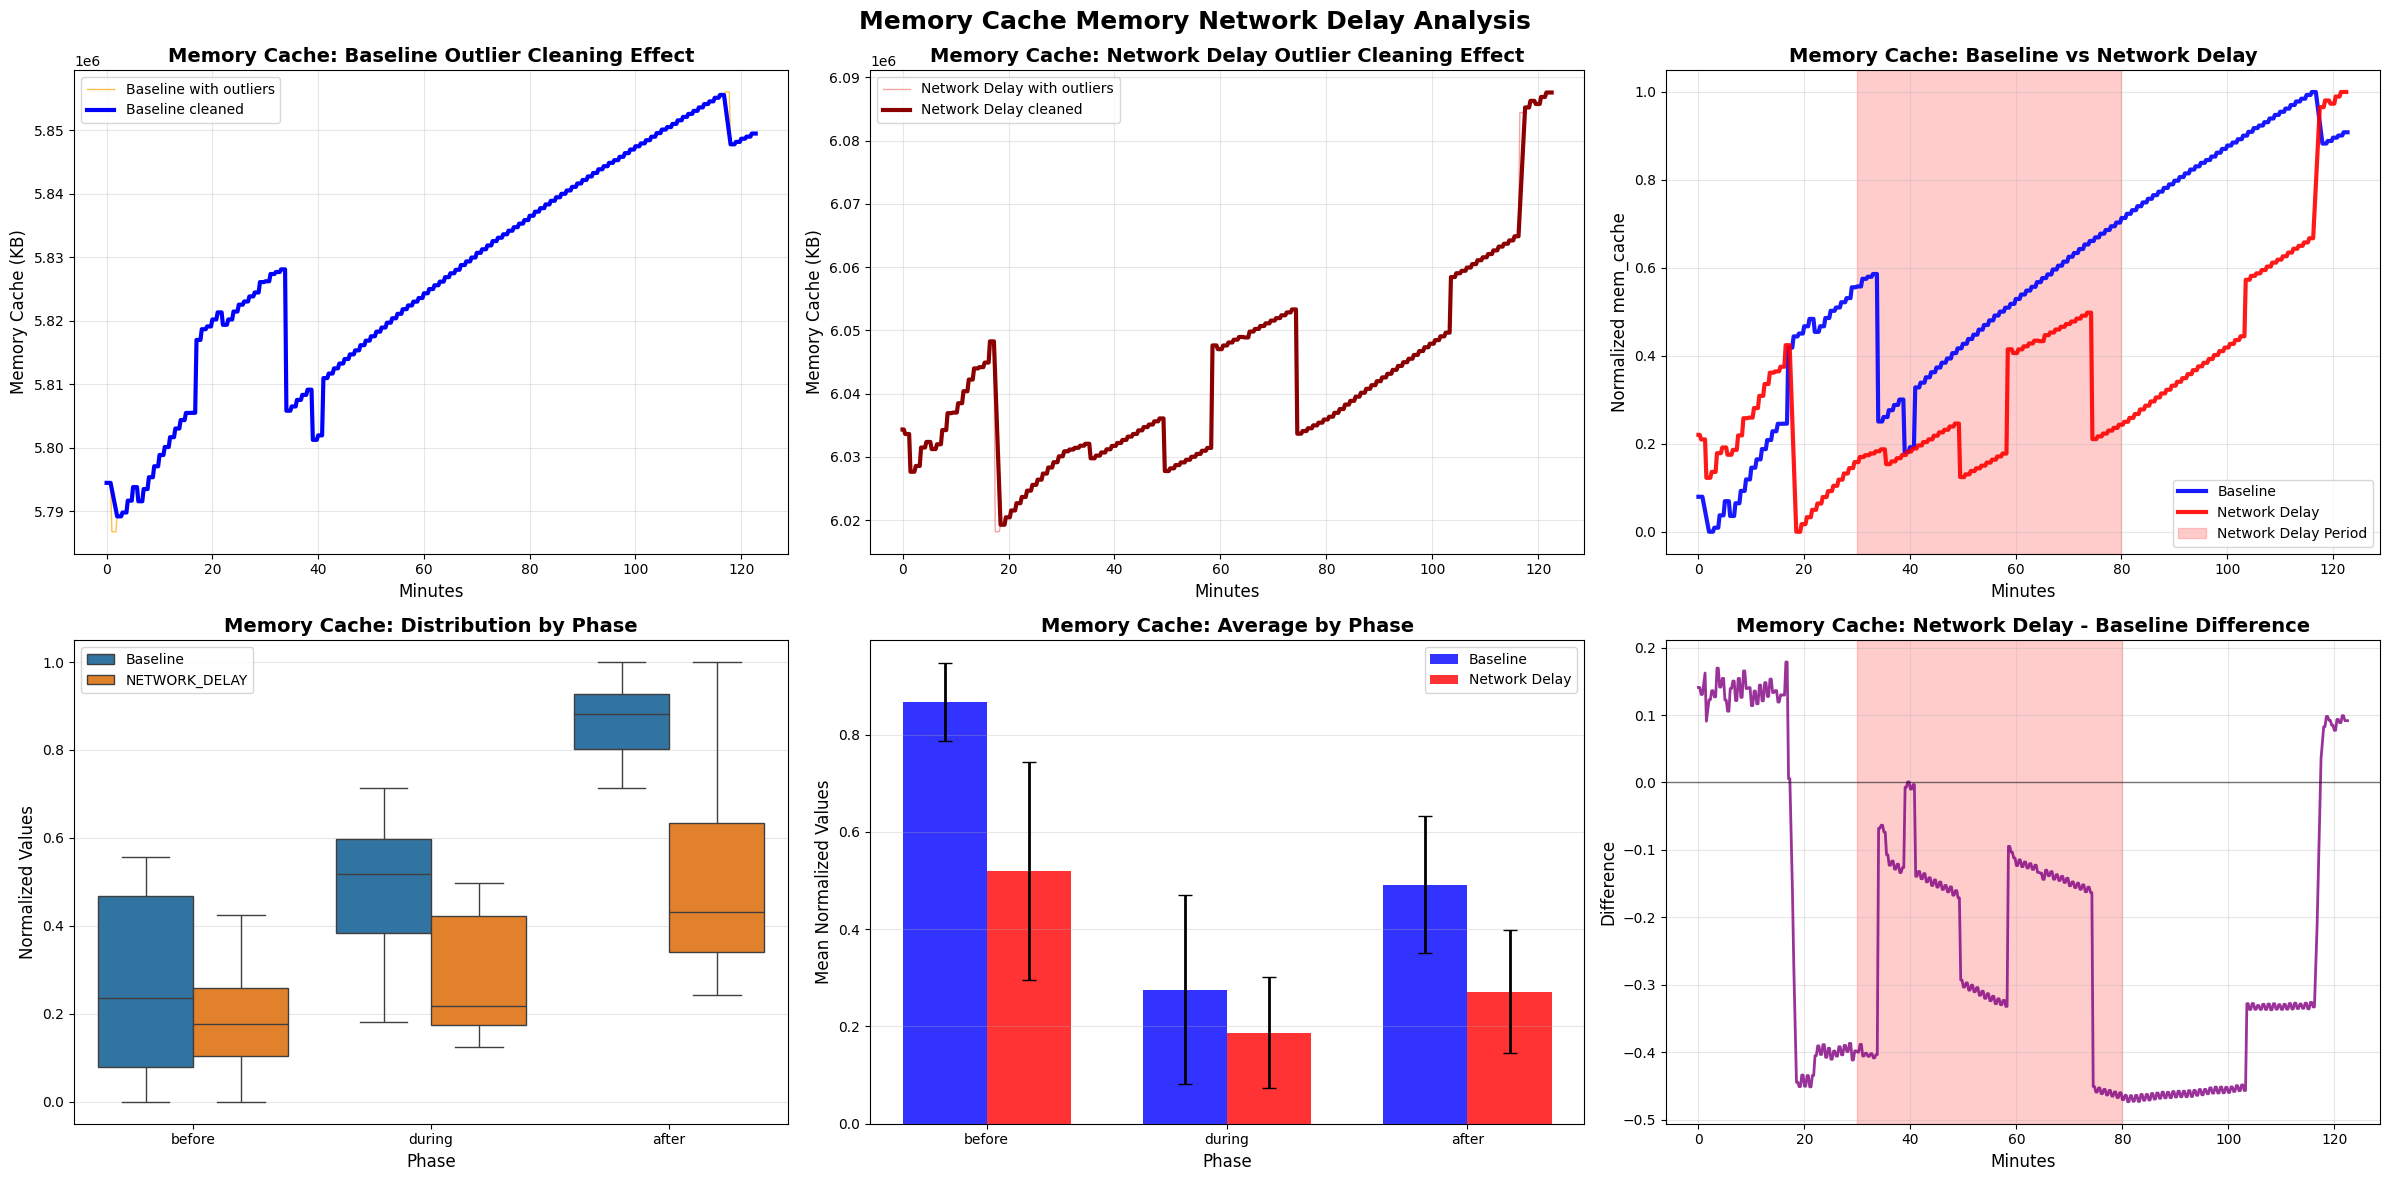


MEMORY CACHE - NETWORK DELAY ANALYSIS RESULTS

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.8673  0.0798  0.7134  1.0000
before  0.2756  0.1949  0.0000  0.5559
during  0.4914  0.1404  0.1815  0.7134

NETWORK DELAY STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.5202  0.2245  0.2434  1.0000
before  0.1875  0.1141  0.0000  0.4242
during  0.2712  0.1268  0.1242  0.4982

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  4.27, p=  0.0000 (SIGNIFICANT)
  DURING  : t= 16.50, p=  0.0000 (SIGNIFICANT)
  AFTER   : t= 19.05, p=  0.0000 (SIGNIFICANT)

NETWORK DELAY IMPACT ON MEMORY:
  BEFORE  :  -31.96% (DECREASE)
  DURING  :  -44.81% (DECREASE)
  AFTER   :  -40.03% (DECREASE)

MEMORY METRICS SUMMARY:
  Numeric columns found: ['mem_cache']
  Main metric analyzed: mem_cache
  Total metrics: 1

Analyzing Memory Available...

Plotting original memory data for Memory Ava

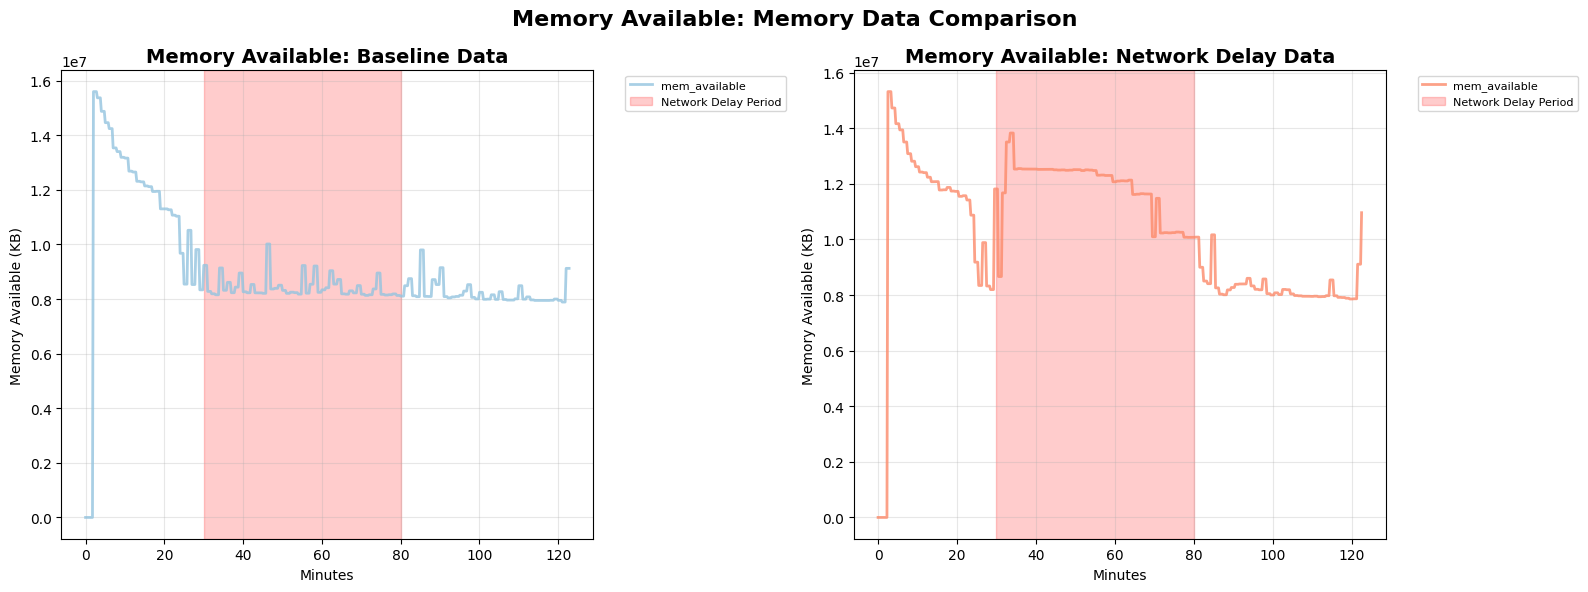

  Displayed all 1 memory columns: mem_available


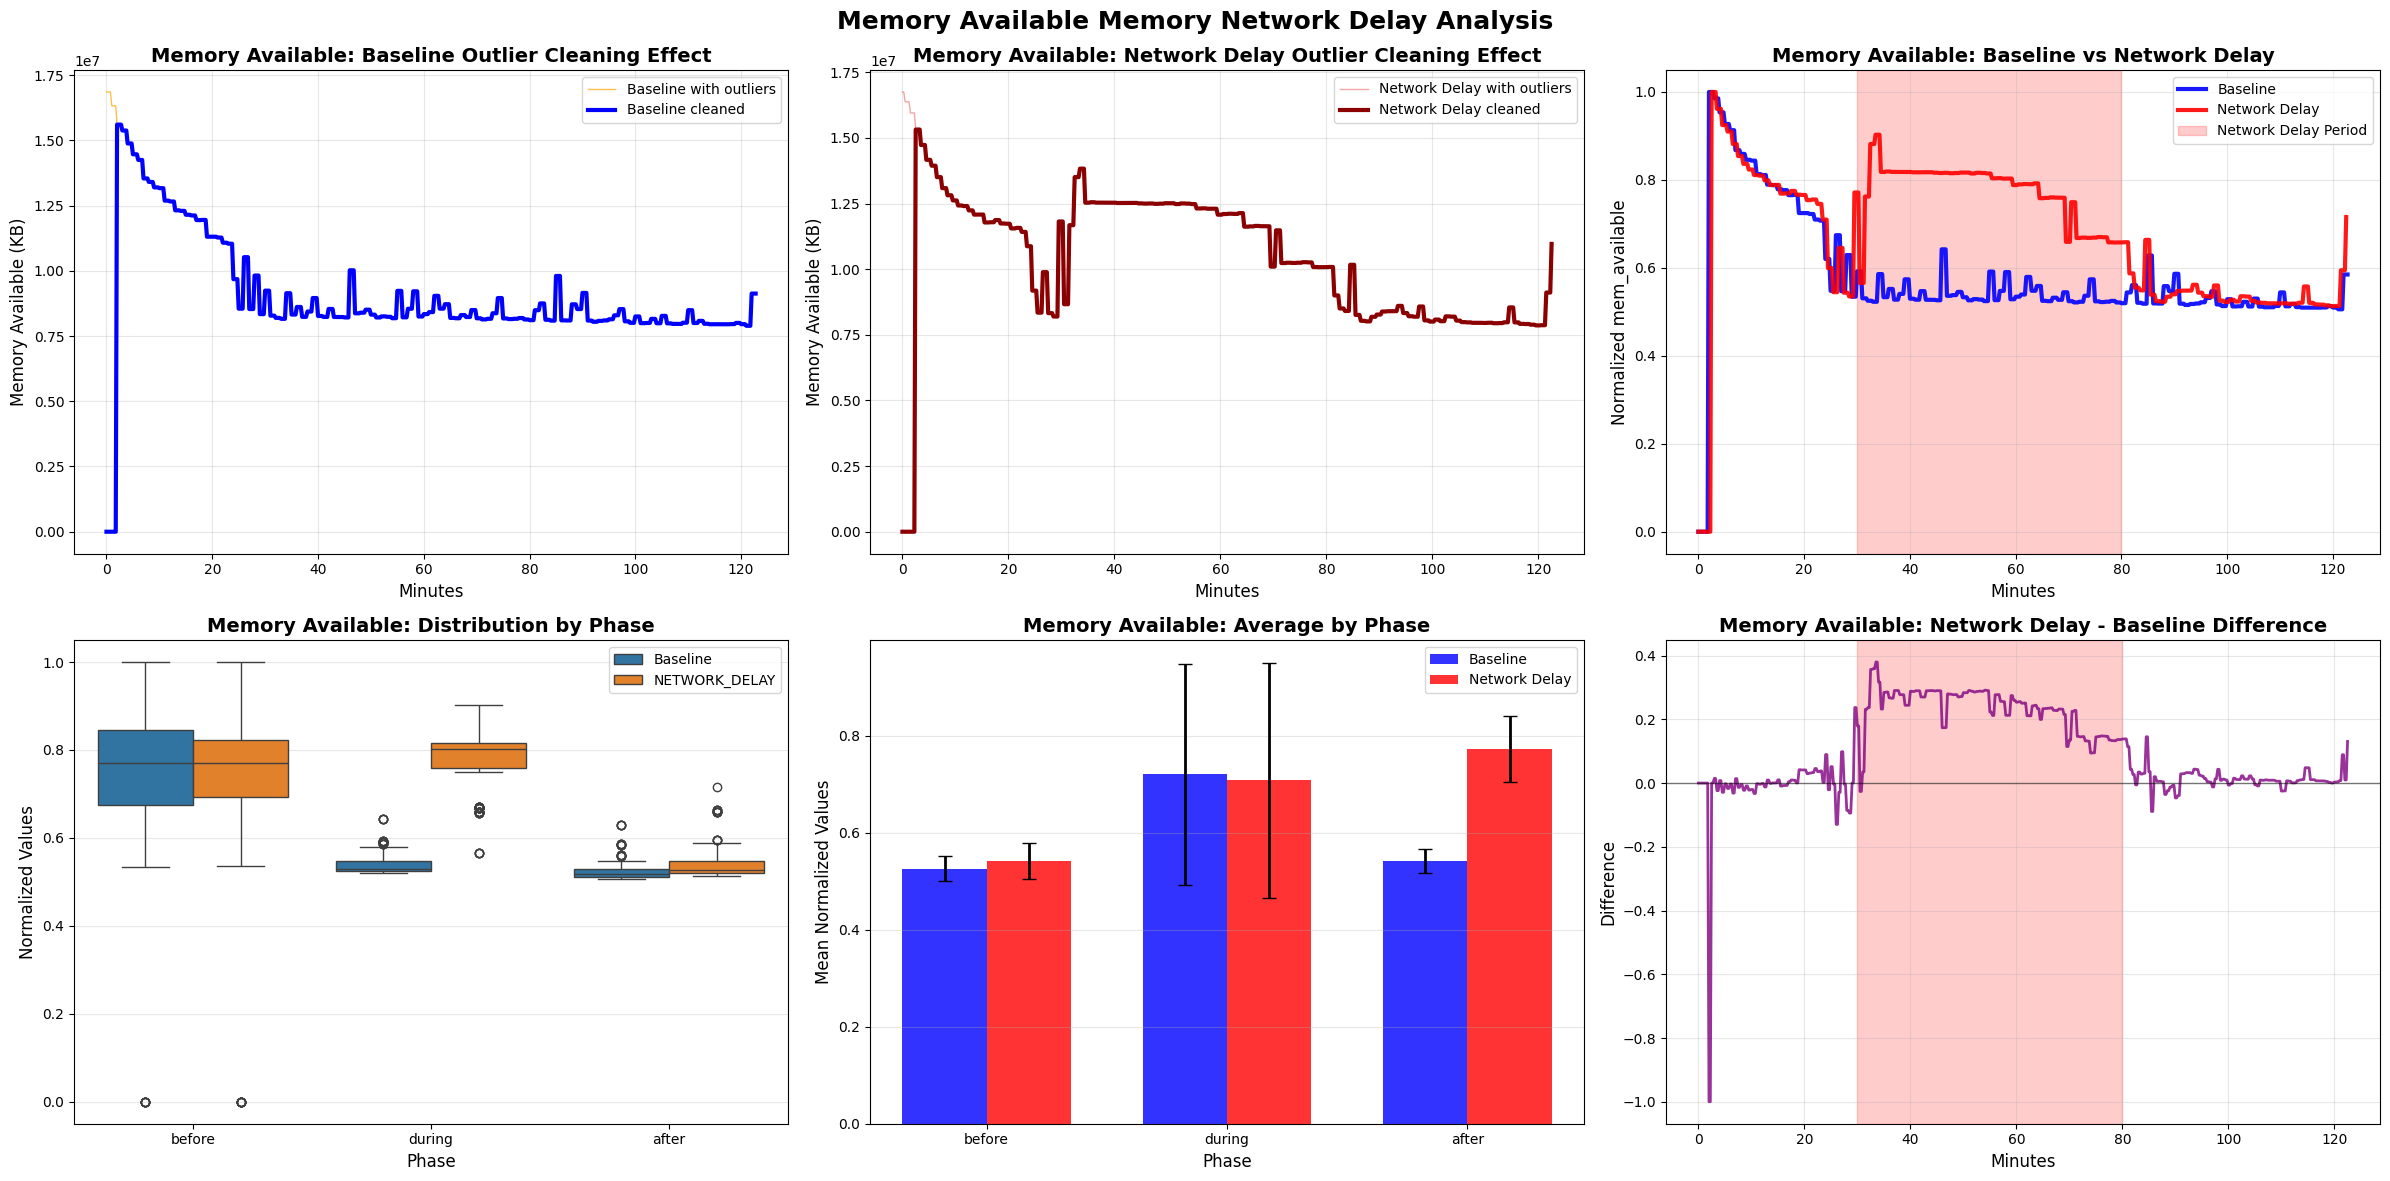


MEMORY AVAILABLE - NETWORK DELAY ANALYSIS RESULTS

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.5265  0.0249  0.5058  0.6282
before  0.7209  0.2279  0.0000  1.0000
during  0.5412  0.0248  0.5197  0.6422

NETWORK DELAY STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.5416  0.0366  0.5130  0.7156
before  0.7085  0.2418  0.0000  1.0000
during  0.7730  0.0683  0.5657  0.9028

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  0.41, p=  0.6823 (NOT SIGNIFICANT)
  DURING  : t=-45.24, p=  0.0000 (SIGNIFICANT)
  AFTER   : t= -4.46, p=  0.0000 (SIGNIFICANT)

NETWORK DELAY IMPACT ON MEMORY:
  BEFORE  :   -1.72% (DECREASE)
  DURING  :  +42.83% (INCREASE)
  AFTER   :   +2.87% (INCREASE)

MEMORY METRICS SUMMARY:
  Numeric columns found: ['mem_available']
  Main metric analyzed: mem_available
  Total metrics: 1


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load all memory datasets
df_mem_util = pd.read_csv("mem_util.csv")
df_mem_cache = pd.read_csv("mem_cache.csv")
df_mem_available = pd.read_csv("mem_available.csv")

df_baseline_mem_util = pd.read_csv("../../baseline/memory related/mem_util.csv")
df_baseline_mem_cache = pd.read_csv("../../baseline/memory related/mem_cache.csv")
df_baseline_mem_available = pd.read_csv("../../baseline/memory related/mem_available.csv")

# Add source labels for network delay experiment
df_mem_util["source"] = "NETWORK_DELAY"
df_mem_cache["source"] = "NETWORK_DELAY"
df_mem_available["source"] = "NETWORK_DELAY"

df_baseline_mem_util["source"] = "BASELINE"
df_baseline_mem_cache["source"] = "BASELINE"
df_baseline_mem_available["source"] = "BASELINE"

# Convert to datetime
df_mem_util["Time"] = pd.to_datetime(df_mem_util["Time"])
df_mem_cache["Time"] = pd.to_datetime(df_mem_cache["Time"])
df_mem_available["Time"] = pd.to_datetime(df_mem_available["Time"])

df_baseline_mem_util["Time"] = pd.to_datetime(df_baseline_mem_util["Time"])
df_baseline_mem_cache["Time"] = pd.to_datetime(df_baseline_mem_cache["Time"])
df_baseline_mem_available["Time"] = pd.to_datetime(df_baseline_mem_available["Time"])

delay = 30
duration = 50

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_mem_util["Time"].min() - df_mem_util["Time"].min()
df_mem_util["Time"] += time_offset
df_mem_cache["Time"] += time_offset
df_mem_available["Time"] += time_offset

# Convert timeline to minutes
all_dfs = [
    df_mem_util, df_mem_cache, df_mem_available,
    df_baseline_mem_util, df_baseline_mem_cache, df_baseline_mem_available
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# Store original datasets before cleaning
original_datasets = {
    'Memory Utilization': {'networkdelay': df_mem_util.copy(), 'baseline': df_baseline_mem_util.copy()},
    'Memory Cache': {'networkdelay': df_mem_cache.copy(), 'baseline': df_baseline_mem_cache.copy()},
    'Memory Available': {'networkdelay': df_mem_available.copy(), 'baseline': df_baseline_mem_available.copy()}
}

# Simple isolation forest outlier detection for memory metrics
def remove_outliers_isolation_forest_memory(df, contamination=0.02):
    """Simple Isolation Forest outlier detection - uses only original numeric columns"""
    df_clean = df.copy()
    outlier_stats = {}
    
    # Get all numeric columns except Time, Minutes, and source
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    if len(numeric_cols) == 0:
        outlier_stats['_summary'] = {
            'total_outliers': 0,
            'contamination_rate': contamination,
            'features_used': 0,
            'percentage_removed': 0
        }
        return df_clean, outlier_stats
    
    # Use only the original numeric columns
    feature_matrix = df[numeric_cols].fillna(0).values
    
    # Check if there's enough variance to detect outliers
    if np.std(feature_matrix.flatten()) > 1e-10:
        # Scale features for better performance
        scaler = StandardScaler()
        feature_matrix_scaled = scaler.fit_transform(feature_matrix)
        
        # Initialize and fit Isolation Forest
        iso_forest = IsolationForest(
            contamination=contamination,
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )
        
        # Fit and predict
        iso_forest.fit(feature_matrix_scaled)
        outlier_predictions = iso_forest.predict(feature_matrix_scaled)
        
        # Create outlier mask
        outlier_mask = outlier_predictions == -1
        
        # Apply outlier removal to each numeric column
        for col in numeric_cols:
            outlier_stats[col] = {
                'count': outlier_mask.sum(),
                'percentage': (outlier_mask.sum() / len(df[col])) * 100,
                'method': 'isolation_forest_simple'
            }
            
            # Set outliers to NaN and interpolate
            df_clean.loc[outlier_mask, col] = np.nan
            df_clean[col] = df_clean[col].interpolate(method='linear').fillna(0)
        
        # Overall statistics
        outlier_stats['_summary'] = {
            'total_outliers': outlier_mask.sum(),
            'contamination_rate': contamination,
            'features_used': len(numeric_cols),
            'percentage_removed': (outlier_mask.sum() / len(df)) * 100
        }
    else:
        # No variance - no outliers to remove
        for col in numeric_cols:
            outlier_stats[col] = {
                'count': 0,
                'percentage': 0,
                'method': 'isolation_forest_simple'
            }
        
        outlier_stats['_summary'] = {
            'total_outliers': 0,
            'contamination_rate': contamination,
            'features_used': len(numeric_cols),
            'percentage_removed': 0
        }
    
    return df_clean, outlier_stats

# Outlier cleaning with tracking
datasets_clean = {}
all_outlier_stats = {}

for dataset_name, dataset_pair in original_datasets.items():
    print(f"\nProcessing {dataset_name} with Simple Isolation Forest:")
    
    datasets_clean[dataset_name] = {}
    all_outlier_stats[dataset_name] = {}
    
    for source_type, df in dataset_pair.items():
        print(f"  {source_type.upper().replace('_', ' ')}:")
        
        # Apply Simple Isolation Forest outlier detection
        df_clean, stats = remove_outliers_isolation_forest_memory(df, contamination=0.02)
        
        datasets_clean[dataset_name][source_type] = df_clean
        all_outlier_stats[dataset_name][source_type] = stats
        
        # Print outlier summary
        total_outliers = stats['_summary']['total_outliers']
        features_used = stats['_summary']['features_used']
        percentage_removed = stats['_summary']['percentage_removed']
        print(f"    Cleaned {total_outliers} outliers ({percentage_removed:.1f}%) using {features_used} original features")

# Normalization function
def normalize_df_memory(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result

# Add phase column 
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df

# Function to get appropriate y-axis label based on dataset
def get_y_axis_label(dataset_name, column_name):
    if 'Memory Utilization' in dataset_name:
        return 'Memory Utilization (%)'
    elif 'Memory Cache' in dataset_name:
        return 'Memory Cache (KB)'
    elif 'Memory Available' in dataset_name:
        return 'Memory Available (KB)'
    else:
        return column_name

# Simple function to plot original memory data
def plot_original_memory_data(dataset_name, networkdelay_df, baseline_df, delay_minutes, duration_minutes):
    """
    Plot 2 simple plots: one for baseline data and one for Network Delay data
    Shows all memory columns in their original form
    """
    # Get all numeric columns except Time, Minutes
    numeric_cols = [col for col in networkdelay_df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    if len(numeric_cols) == 0:
        print(f"No numeric columns found in {dataset_name}")
        return
    
    print(f"  Showing all {len(numeric_cols)} memory metrics")
    display_cols = numeric_cols
    
    # Create 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Baseline Data
    colors_baseline = plt.cm.Blues(np.linspace(0.4, 0.9, len(display_cols)))
    for i, col in enumerate(display_cols):
        ax1.plot(baseline_df['Minutes'], baseline_df[col], 
                color=colors_baseline[i], linewidth=2, alpha=0.8, 
                label=col)
    
    ax1.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Network Delay Period")
    ax1.set_title(f'{dataset_name}: Baseline Data', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Minutes')
    ax1.set_ylabel(get_y_axis_label(dataset_name, display_cols[0]))
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Plot 2: Network Delay Data
    colors_stress = plt.cm.Reds(np.linspace(0.4, 0.9, len(display_cols)))
    for i, col in enumerate(display_cols):
        ax2.plot(networkdelay_df['Minutes'], networkdelay_df[col], 
                color=colors_stress[i], linewidth=2, alpha=0.8, 
                label=col)
    
    ax2.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Network Delay Period")
    ax2.set_title(f'{dataset_name}: Network Delay Data', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Minutes')
    ax2.set_ylabel(get_y_axis_label(dataset_name, display_cols[0]))
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    plt.suptitle(f'{dataset_name}: Memory Data Comparison', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"  Displayed all {len(numeric_cols)} memory columns: {', '.join(numeric_cols)}")

# Enhanced analysis and plot function for memory metrics
def analyze_and_plot_memory_dataset_wide(dataset_name, networkdelay_df_clean, baseline_df_clean, delay_minutes, duration_minutes):
    
    # Plot the original data first
    print(f"\nPlotting original memory data for {dataset_name}...")
    plot_original_memory_data(dataset_name, networkdelay_df_clean, baseline_df_clean, delay_minutes, duration_minutes)
    
    # Get original datasets for comparison
    networkdelay_df_original = original_datasets[dataset_name]['networkdelay']
    baseline_df_original = original_datasets[dataset_name]['baseline']
    
    # Get numeric columns for memory metrics
    numeric_cols = [col for col in networkdelay_df_clean.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    networkdelay_norm = normalize_df_memory(networkdelay_df_clean, numeric_cols)
    baseline_norm = normalize_df_memory(baseline_df_clean, numeric_cols)
    
    # For memory metrics, we typically have single metrics, so we'll use the main metric
    main_metric = numeric_cols[0] if numeric_cols else None
    
    if main_metric is None:
        print(f"No numeric columns found for {dataset_name}")
        return None
    
    # Add phase information
    networkdelay_norm = add_phase_column(networkdelay_norm, delay_minutes, duration_minutes)
    baseline_norm = add_phase_column(baseline_norm, delay_minutes, duration_minutes)
    
    # Statistical analysis
    stats_baseline = baseline_norm.groupby('phase')[main_metric].agg(['mean', 'std', 'min', 'max'])
    stats_networkdelay = networkdelay_norm.groupby('phase')[main_metric].agg(['mean', 'std', 'min', 'max'])
    
    # Combined dataframe for analysis
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm[main_metric],
        'NETWORK_DELAY': networkdelay_norm[main_metric],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': networkdelay_norm[main_metric] - baseline_norm[main_metric]
    })
    
    # T-tests for statistical significance
    t_tests = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['NETWORK_DELAY'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
    
    # Calculate percentage impact
    impact = {}
    for phase in ['before', 'during', 'after']:
        baseline_mean = stats_baseline.loc[phase, 'mean']
        networkdelay_mean = stats_networkdelay.loc[phase, 'mean']
        impact[phase] = ((networkdelay_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else float('inf')
    
    # Comprehensive analysis plotting
    fig = plt.figure(figsize=(24, 12))
    
    # 1. Baseline outlier cleaning effect
    plt.subplot(2, 3, 1)
    plt.plot(baseline_df_original['Minutes'], baseline_df_original[main_metric], 
             label='Baseline with outliers', color='orange', alpha=0.7, linewidth=1)
    plt.plot(baseline_df_clean['Minutes'], baseline_df_clean[main_metric], 
             label='Baseline cleaned', linewidth=3, color='blue')
    plt.title(f'{dataset_name}: Baseline Outlier Cleaning Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(get_y_axis_label(dataset_name, main_metric), fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. Network delay outlier cleaning effect
    plt.subplot(2, 3, 2)
    plt.plot(networkdelay_df_original['Minutes'], networkdelay_df_original[main_metric], 
             label='Network Delay with outliers', alpha=0.7, color='lightcoral', linewidth=1)
    plt.plot(networkdelay_df_clean['Minutes'], networkdelay_df_clean[main_metric], 
             label='Network Delay cleaned', linewidth=3, color='darkred')
    plt.title(f'{dataset_name}: Network Delay Outlier Cleaning Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(get_y_axis_label(dataset_name, main_metric), fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Timeline comparison
    plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm[main_metric], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(networkdelay_norm['Minutes'], networkdelay_norm[main_metric], 
             label='Network Delay', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Network Delay Period")
    plt.title(f"{dataset_name}: Baseline vs Network Delay", fontsize=14, fontweight='bold')
    plt.xlabel("Minutes", fontsize=12)
    plt.ylabel(f"Normalized {main_metric}", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # 4. Box plot by phase
    plt.subplot(2, 3, 4)
    box_data = pd.melt(df_combined[['Baseline', 'NETWORK_DELAY', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{dataset_name}: Distribution by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=10)
    
    # 5. Statistics by phase
    plt.subplot(2, 3, 5)
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, stats_networkdelay['mean'], width, label='Network Delay', alpha=0.8, color='red')
    
    plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    plt.errorbar(x + width/2, stats_networkdelay['mean'], yerr=stats_networkdelay['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    plt.title(f'{dataset_name}: Average by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Mean Normalized Values', fontsize=12)
    plt.xticks(x, phases)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Difference over time
    plt.subplot(2, 3, 6)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{dataset_name}: Network Delay - Baseline Difference', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{dataset_name} Memory Network Delay Analysis', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    # Print statistical results
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} - NETWORK DELAY ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    print(f"\nBASELINE STATISTICS BY PHASE:")
    print(stats_baseline.round(4))
    
    print(f"\nNETWORK DELAY STATISTICS BY PHASE:")
    print(stats_networkdelay.round(4))
    
    print(f"\nSTATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        sig = "SIGNIFICANT" if test['p'] < 0.05 else "NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")
    
    print(f"\nNETWORK DELAY IMPACT ON MEMORY:")
    for phase, change in impact.items():
        direction = "INCREASE" if change > 0 else "DECREASE" if change < 0 else "NO CHANGE"
        print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")
    
    # Print memory metrics summary
    print(f"\nMEMORY METRICS SUMMARY:")
    print(f"  Numeric columns found: {numeric_cols}")
    print(f"  Main metric analyzed: {main_metric}")
    print(f"  Total metrics: {len(numeric_cols)}")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_networkdelay': stats_networkdelay,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'main_metric': main_metric,
        'numeric_columns': numeric_cols
    }

# Run analysis 
print(f"\n{'='*80}")
print("COMPREHENSIVE MEMORY NETWORK DELAY ANALYSIS")
print(f"{'='*80}")

analysis_results = {}

for dataset_name in datasets_clean.keys():
    print(f"\nAnalyzing {dataset_name}...")
    
    networkdelay_clean = datasets_clean[dataset_name]['networkdelay']
    baseline_clean = datasets_clean[dataset_name]['baseline']
    
    analysis_results[dataset_name] = analyze_and_plot_memory_dataset_wide(
        dataset_name, 
        networkdelay_clean, 
        baseline_clean, 
        delay, 
        duration
    )